# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test.

Le notebook sera déposé sur la plateforme moodle du cours.

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""
from google.colab import drive
drive.mount('/content/drive/')
dataset_path = '/content/drive/MyDrive/AI_ML/mushrooms'
"""

dataset_path = 'mushrooms'

In [3]:
def Data():
    data_dir = dataset_path
    classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls)) and not cls.startswith('.')]
    
    print("Classes:", classes)

    data_list = []
    for label in classes:
        image_files = os.listdir(os.path.join(data_dir,label))
        data_list.extend([(label,os.path.join(data_dir,label,f)) for f in image_files])

    print("Nombre d'images total:",len(data_list))
    print("Nombre d'images par classes:",[len(os.listdir(os.path.join(data_dir,label))) for label in classes])

    return data_list


In [4]:
data_list = Data()

Classes: ['crimini', 'oyster', 'amanita']
Nombre d'images total: 1643
Nombre d'images par classes: [561, 547, 535]


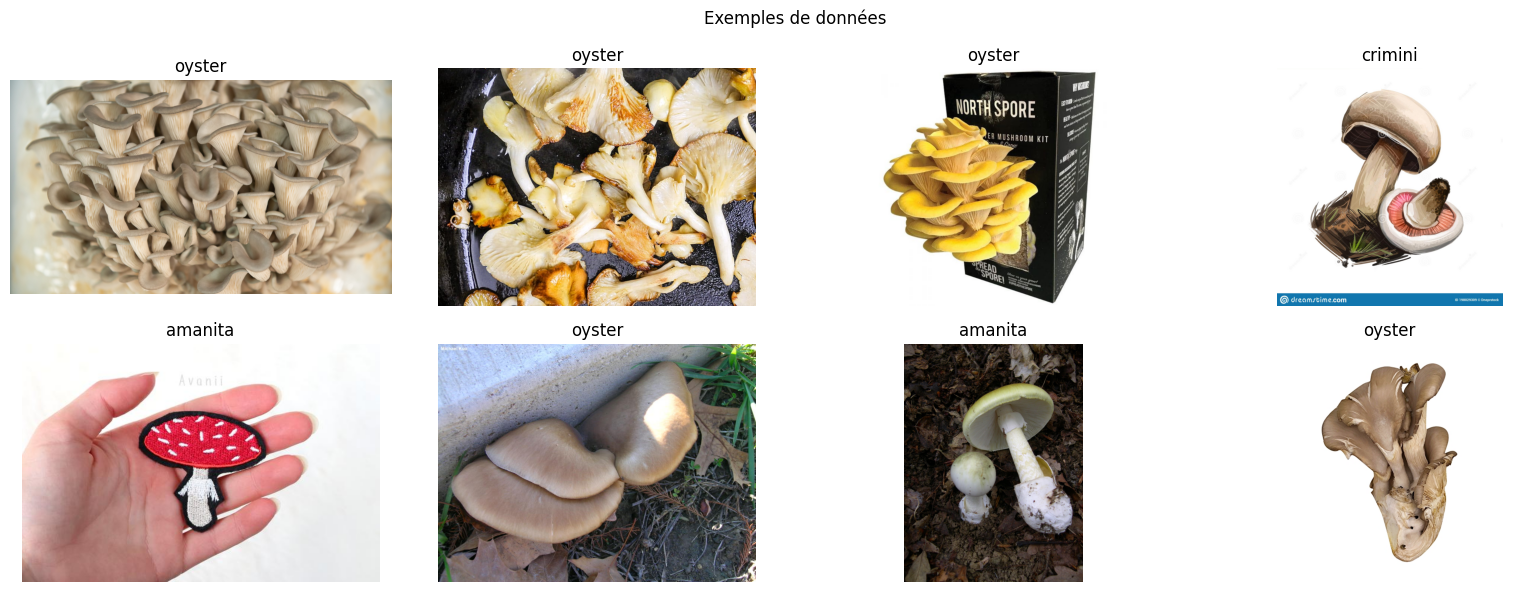

In [5]:
image_samples = np.random.randint(0,high=len(data_list)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(data_list[img_idx][0])
    image = Image.open(data_list[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

# Preprocessing

In [6]:
from collections import Counter

def img_size(path):
    size_counter = Counter()
    total_image = 0
    max_size = (0,0)

    for root, _, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    size = img.size
                    size_counter[size] += 1
                    total_image += 1
                    if size > max_size:
                        max_size = size
            except Exception as e:
                print(f"FILE {file_path}: {e}")
    print("Total: ", total_image)
    print("Max Size:", max_size)
    for size, count in size_counter.most_common():
        print(f"SIZE { size }: {count}")

img_size(dataset_path)

FILE mushrooms/.DS_Store: cannot identify image file '/Users/neil/Code/ZZ3/AI_ML/Challenge/mushrooms/.DS_Store'
Total:  1643
Max Size: (4288, 2848)
SIZE (600, 600): 32
SIZE (300, 300): 21
SIZE (1000, 1000): 21
SIZE (800, 800): 20
SIZE (612, 408): 17
SIZE (1200, 1200): 17
SIZE (1024, 768): 16
SIZE (500, 500): 16
SIZE (1280, 720): 16
SIZE (1024, 1024): 15
SIZE (1000, 750): 13
SIZE (612, 612): 12
SIZE (1024, 512): 12
SIZE (600, 900): 12
SIZE (1024, 683): 12
SIZE (600, 400): 12
SIZE (390, 280): 11
SIZE (800, 600): 11
SIZE (1500, 1500): 9
SIZE (640, 480): 9
SIZE (680, 1019): 8
SIZE (683, 1024): 7
SIZE (1000, 1500): 7
SIZE (800, 533): 7
SIZE (400, 300): 7
SIZE (640, 640): 6
SIZE (250, 250): 6
SIZE (512, 384): 6
SIZE (1000, 667): 6
SIZE (1000, 1333): 6
SIZE (350, 350): 6
SIZE (375, 500): 6
SIZE (1600, 1200): 6
SIZE (750, 350): 6
SIZE (800, 1200): 6
SIZE (600, 450): 6
SIZE (1200, 600): 6
SIZE (1200, 1800): 5
SIZE (735, 1102): 5
SIZE (1200, 800): 5
SIZE (700, 700): 5
SIZE (1300, 866): 5
SIZE (3

In [7]:
import torch
import torchvision
from torchvision import transforms


def dataset(
    dataset_path: str,
    train_size: float = 0.7,
    val_size: float = 0.15,
    seed: int = 42,
    batch_size: int = 32,
    num_workers: int = 4
):

  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(1024),  # Randomly crop and resize the image
      transforms.RandomHorizontalFlip(),  # Randomly reverse
      transforms.RandomRotation(10),  # Randomly rotate
      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly change the brightness, contrast, saturation and hue
      transforms.RandomVerticalFlip(),  # Randomly reverse
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Seed from torchvision
  ])

  val_transform = transforms.Compose([
      transforms.Resize(1024),
      transforms.CenterCrop(1024),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=train_transform)

  train_set = int(len(dataset) * train_size) # To train the model
  val_set = int(len(dataset) * val_size)  # To tune hyperparameters
  test_set = int(len(dataset) - train_set - val_set) # To evaluate the performance

  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_set, val_set, test_set], generator=torch.Generator().manual_seed(seed))

  val_dataset.dataset.transform = val_transform
  test_dataset.dataset.transform = val_transform

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

  return train_loader, val_loader, test_loader


# Define the Model

In order to achieve better results in the competition, we decided to use a deeper network. However, due to the limited size of the dataset, we decided to use a residual network to avoid overfitting.

## Backbone

ResNet-18
[Deep Residual Learning for Image Recognition (arXiv:1512.03385)](https://arxiv.org/abs/1512.03385)

"""mermaid
graph TB
    A[Input Image] --> B[Conv 7x7, Stride 2, 64 Filters]
    B --> C[MaxPool 3x3, Stride 2]
    C --> D1[Residual Block x2, 64 Filters]
    D1 --> D2[Residual Block x2, 128 Filters, Stride 2]
    D2 --> D3[Residual Block x2, 256 Filters, Stride 2]
    D3 --> D4[Residual Block x2, 512 Filters, Stride 2]
    D4 --> E[Adaptive AvgPool]
    E --> F[FC Layer, 1000 Classes]
"""


In [8]:
from IPython.core.display import display, HTML
mermaid = """
<div class="mermaid">
graph TB
    A[Input Image] --> B[Conv 7x7, Stride 2, 64 Filters]
    B --> C[MaxPool 3x3, Stride 2]
    C --> D1[Residual Block x2, 64 Filters]
    D1 --> D2[Residual Block x2, 128 Filters, Stride 2]
    D2 --> D3[Residual Block x2, 256 Filters, Stride 2]
    D3 --> D4[Residual Block x2, 512 Filters, Stride 2]
    D4 --> E[Adaptive AvgPool]
    E --> F[FC Layer, 1000 Classes]
</div>
<script src="https://cdnjs.cloudflare.com/ajax/libs/mermaid/10.4.0/mermaid.min.js"></script>
<script>
  mermaid.initialize({startOnLoad:true});
</script>
"""
display(HTML(mermaid))

/var/folders/g_/7bh1l5yd0717vlgf8v9b0j3h0000gn/T/ipykernel_54470/3181899147.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [9]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 31 * 31, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [12]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
model = AlexNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

train_loader, val_loader, test_loader = dataset(
    dataset_path,
    batch_size=8
)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}")

    torch.save(model.state_dict(), f"resnet18_{epoch+1}.pt")

Device: mps


RuntimeError: MPS backend out of memory (MPS allocated: 18.06 GB, other allocations: 896.00 KB, max allowed: 18.13 GB). Tried to allocate 3.75 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).